### 2D Diffusion Equation :
$$ -\frac{\partial}{\partial x}D(x,y)\frac{\partial}{\partial x}\phi(x,y) - -\frac{\partial}{\partial y}D(x,y)\frac{\partial}{\partial y}\phi(x,y) + \Sigma_a(x,y)\phi(x,y) = S(x,y)$$



### Descritized with FVM:
Assumption: $$ D(x,y) = D_{i,j} $$
$$ \Sigma_{a}(x,y) = \Sigma_{a,i,j}  $$
$$ S(x,y) = S_{i,j}  $$
$$ \Delta x_i \equiv \delta_i = x_i-x_{i-1}  $$
$$ \Delta y_i \equiv \delta_i = y_j-y_{j-1}  $$
Aborption Term:
$$ \Sigma_{a,ij} = \phi_{i,j}(\Sigma_{a,i,j}V_{i,j} + \Sigma_{a,i+1,j}V_{i+1,j} + \Sigma_{a,i+1,j+}V_{i+1,j+} + \Sigma_{a,i,j+1}V_{i,j+1}) $$

Source term:
$$S_{ij} = S_{i,j}V_{i,j} + S_{i+1,j}V_{i+1,j} + S_{i+1,j+1}V_{i+1,j+1} + S_{i,j+1}V_{i,j+1}$$

Where: $$ V_{i,j} = \frac{1}{4}\delta_i\epsilon_j$$
$$ V_{i+1,j} = \frac{1}{4}\delta_{i+1}\epsilon_j$$
$$ V_{i+1,j+1} = \frac{1}{4}\delta_{i+1}\epsilon_{j+1}$$
$$ V_{i,j+1} = \frac{1}{4}\delta_{i}\epsilon_{j+1}$$

$$S_{ij} = a^{ij}_{i-1,j} \phi_{i-1,j} + a^{ij}_{i+1,j} \phi_{i+1,j} + a^{ij}_{i,j-1} \phi_{i,j-1} + a^{ij}_{i,j+1} \phi_{i,j+1} + a^{ij}_{i,j} \phi_{i,j}$$

Where: $$ a^{ij}_{i-1,j} = -\frac{D_{i,j}\epsilon_{j}+D_{i,j+1}\epsilon_{j+1}}{2\delta_{i}}$$
$$ a^{ij}_{i+1,j} = -\frac{D_{i+1,j}\epsilon_{j}+D_{i+1,j+1}\epsilon_{j+1}}{2\delta_{i+1}}$$
$$ a^{ij}_{i,j-1} = -\frac{D_{i,j}\delta_{i}+D_{i+1,j}\delta_{i+1}}{2\epsilon_{j}}$$
$$ a^{ij}_{i,j+1} = \frac{D_{i,j+1}\delta_{i}+D_{i+1,j+1}\delta_{i+1}}{2\epsilon_{j+1}}$$
$$ a^{ij}_{i,j} = \Sigma_{a,ij}-(a^{ij}_{i-1,j} + a^{ij}_{i+1,j} + a^{ij}_{i,j-1} + a^{ij}_{i,j+1})$$

![title](NSDE_2D.jpg)

Boundary Conditions:$$ $$
(1) Corners: $\phi_{0,0} = \Phi_B$,  $\phi_{n,0} = \Phi_R$,  $\phi_{0,m} = \Phi_L$,  $\phi_{n,m} = \Phi_T$
$$ $$
(2) Edges:  $$\phi_{0,j} = \Phi_L \ \ \ \ j = 1,...,m-1$$
$$\phi_{n,j} = \Phi_R \ \ \ \ j = 1,...,m-1$$
$$\phi_{i,0} = \Phi_B \ \ \ \   i = 1,...,n-1$$
$$\phi_{i,m} = \Phi_T \ \ \ \ i = 1,...,n-1$$

In [48]:
import numpy as np

In [49]:
def it_gauss_sedidel(A, b, x, e):
    '''
    Ax = b with n iterations until error < e
    '''
    solutions = []
    L = np.tril(A)
    n = 1
    x = np.dot(np.linalg.inv(L), b - np.dot(A-L, x))
    err = 1
    solutions.append(list(x))    
    while err>e:
        x = np.dot(np.linalg.inv(L), b - np.dot(A-L, x))
        solutions.append(list(x))  
        err = np.linalg.norm(x-solutions[-2])/np.linalg.norm(x)
        n+=1
    return n, solutions[-1]

def it_jacobi(A, b, x, e):
    '''
    Ax = b with n iterations until error < e
    '''
    solutions = []
    D = np.diag(A)
    P = A - np.diagflat(D)
    n = 1
    x = (b - np.dot(P,x))/ D
    err = 1
    solutions.append(list(x))
    while err > e:
        x = (b - np.dot(P,x))/ D
        solutions.append(list(x))        
        err = np.linalg.norm(x-solutions[-2])/np.linalg.norm(x)
        n += 1
    return n, solutions[-1]

def it_sor(A, b, x, e, w = 1.1):
    '''
    Ax = b with n iterations until error < e
    ''' 
    solutions = []    
    shape = np.shape(A)
    m = shape[0]
    x1 = x[:]
    D=np.diagonal(A)
    for i in range(m):
        x1[i] = (1-w)*x[i]+(w*(b[i]-np.dot(A[i,:i],x1[0:i])-np.dot(A[i,i+1:],x[i+1:]))/D[i])
        solutions.append(list(x1)) 
    x = x1
    n = 1
    err = 1
    while err > e:
        for i in range(m):
            x1[i] = (1-w)*x[i]+(w*(b[i]-np.dot(A[i,:i],x1[0:i])-np.dot(A[i,i+1:],x[i+1:]))/D[i])
            solutions.append(list(x1))             
        err = np.linalg.norm(x1-solutions[-2])/np.linalg.norm(x1)
        x = x1
        n += 1

    return n, solutions[-1]


def DE_solver(x_pos, y_pos, D_mesh, abs_mesh, source_mesh, err_tol):
    """
    x_pos: position of material along x direction (n+1 by 1)
    y_pos: position of material along y direction (m+1 by 1)
    D_mesh: Diffusion constant distribution over meshes (m by n)
    abs_mesh: Absorption macroscopic cross section distribution over meshes (m by n)
    source_mesh: Fixed source distribution over meshes (m by n)
    """
    m = len(y_pos)-1
    n = len(x_pos)-1
    coeff_matrix = np.zeros(((m+1)*(n+1),(m+1)*(n+1)))
    solution = np.empty(((m+1)*(n+1),1))
    solution.fill(np.nan)
    
    #Absorption: Non corner or edge points    
    abs_list = solution.copy()
    for j in reversed(range(1,m)): #the position starts from bottom left corner
        for i in range(1,n):
            d1=np.abs(x_pos[i]-x_pos[i-1])
            e1=np.abs(y_pos[j]-y_pos[j+1])
            d2=np.abs(x_pos[i+1]-x_pos[i])
            e2=np.abs(y_pos[j-1]-y_pos[j])

            V1=0.25*d1*e1
            V2=0.25*d2*e1
            V3=0.25*d2*e2
            V4=0.25*d1*e2
            
            abs_value = abs_mesh[j,i-1]*V1+abs_mesh[j,i]*V2+abs_mesh[j-1,i]*V3+abs_mesh[j-1,i-1]*V4
            #print(abs_mesh[j,i-1]*V1,abs_mesh[j,i]*V2,abs_mesh[j-1,i]*V3,abs_mesh[j-1,i-1]*V4)
            source_value = source_mesh[j,i-1]*V1+source_mesh[j,i]*V2+source_mesh[j-1,i]*V3+source_mesh[j-1,i-1]*V4
            abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1] = abs_value
            solution[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]= source_value
            
    #Absorption: Reflecting Side Right Points
    for j in reversed(range(1,m)): 
        i=n
        d1=np.abs(x_pos[i]-x_pos[i-1])
        e1=np.abs(y_pos[j]-y_pos[j+1])
        e2=np.abs(y_pos[j-1]-y_pos[j])
        
        V1=0.25*d1*e1
        V4=0.25*d1*e2

        abs_value = abs_mesh[j,i-1]*V1+abs_mesh[j-1,i-1]*V4
        source_value = source_mesh[j,i-1]*V1+source_mesh[j-1,i-1]*V4
        abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1] = abs_value
        solution[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]= source_value       

    #Absorption: Reflecting Side top Points
    for i in range(1,n): 
        j=0
        d1=np.abs(x_pos[i]-x_pos[i-1])
        e1=np.abs(y_pos[j]-y_pos[j+1])
        d2=np.abs(x_pos[i+1]-x_pos[i])
        
        V1=0.25*d1*e1
        V2=0.25*d2*e1

        abs_value = abs_mesh[j,i-1]*V1+abs_mesh[j,i]*V2
        source_value = source_mesh[j,i-1]*V1+source_mesh[j,i]*V2
        abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1] = abs_value
        solution[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]= source_value   
        
    #Absorption: Top Right
    i,j = n,0
    d1=np.abs(x_pos[i]-x_pos[i-1])
    e1=np.abs(y_pos[j]-y_pos[j+1])
    V1=0.25*d1*e1
    abs_value = abs_mesh[j,i-1]*V1
    source_value = source_mesh[j,i-1]*V1
    abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1] = abs_value
    solution[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]= source_value
    
    
    Left=np.empty((n*(m+1),1))
    Left.fill(np.nan)
    Right=np.empty((n*(m+1),1))
    Right.fill(np.nan)
    Bottom=np.empty((m*(n+1),1))
    Bottom.fill(np.nan)
    Top=np.empty((m*(n+1),1))
    Top.fill(np.nan)
    Center=np.empty(((m+1)*(n+1),1))
    Center.fill(np.nan)
    
    #Flux: Non corner or edge points
    for j in reversed(range(1,m)): #the position starts from bottom left corner
        for i in range(1,n):
            d1=np.abs(x_pos[i]-x_pos[i-1])
            e1=np.abs(y_pos[j]-y_pos[j+1])
            d2=np.abs(x_pos[i+1]-x_pos[i])
            e2=np.abs(y_pos[j-1]-y_pos[j])
            
            a_L=-(D_mesh[j,i-1]*e1+D_mesh[j-1,i-1]*e2)/(2*d1)
            a_R=-(D_mesh[j,i]*e1+D_mesh[j-1,i]*e2)/(2*d2)
            a_B=-(D_mesh[j,i-1]*d1+D_mesh[j,i]*d2)/(2*e1)
            a_T=-(D_mesh[j-1,i-1]*d1+D_mesh[j-1,i]*d2)/(2*e2)
            a_C=abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]-(a_L+a_R+a_B+a_T)
            
            Left[((m+1-(j+1))*(n+1-1)+i-1)]=a_L
            Right[((m+1-(j+1))*(n+1-1)+i)]=a_R
            Bottom[(m+1-(j+1)-1)*(n+1)+i]=a_B
            Top[(m+1-(j+1))*(n+1)+i]=a_T
            Center[(m+1-(j+1))*(n+1)+i]=a_C
    
    #Flux: Reflecting side right
    for j in reversed(range(1,m)): #the position starts from bottom left corner
        i=n
        d1=np.abs(x_pos[i]-x_pos[i-1])
        e1=np.abs(y_pos[j]-y_pos[j+1])
        #d2=bp.abs(x_pos[i+1]-x_pos[i])
        e2=np.abs(y_pos[j-1]-y_pos[j])

        a_L=-(D_mesh[j,i-1]*e1+D_mesh[j-1,i-1]*e2)/(2*d1)
        #a_R=-(D_mesh[j,i]*e1+D_mesh[j-1,i]*e2)/(2*d2)
        a_B=-(D_mesh[j,i-1]*d1)/(2*e1)
        a_T=-(D_mesh[j-1,i-1]*d1)/(2*e2)
        a_C=abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]-(a_L+a_B+a_T)

        Left[((m+1-(j+1))*(n+1-1)+i-1)]=a_L
        #Right[((m+1-j)*(n+1-1)+i)]=a_R
        Bottom[(m+1-(j+1)-1)*(n+1)+i]=a_B
        Top[(m+1-(j+1))*(n+1)+i]=a_T
        Center[(m+1-(j+1))*(n+1)+i]=a_C 
        
    #Flux: Reflecting side top
    for i in range(1,n): #the position starts from bottom left corner
        j=0
        d1=np.abs(x_pos[i]-x_pos[i-1])
        e1=np.abs(y_pos[j]-y_pos[j+1])
        d2=np.abs(x_pos[i+1]-x_pos[i])
        #e2=np.abs(y_pos[j-1]-y[j])

        a_L=-(D_mesh[j,i-1]*e1)/(2*d1)
        a_R=-(D_mesh[j,i]*e1)/(2*d2)
        a_B=-(D_mesh[j,i-1]*d1+D_mesh[j,i]*d2)/(2*e1)
        #a_T=-(D_mesh[j-1,i-1]*d1+D_mesh[j-1,i]*d2)/(2*e2)
        a_C=abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]-(a_L+a_R+a_B)

        Left[(m+1-(j+1))*(n+1-1)+i-1]=a_L
        Right[((m+1-(j+1))*(n+1-1)+i)]=a_R
        Bottom[(m+1-(j+1)-1)*(n+1)+i]=a_B
        #Top[(m+1-j-1)*(n+1)+i]=a_T
        Center[(m+1-(j+1))*(n+1)+i]=a_C   
    #Flux: Top right
    i,j = n,0
    d1=np.abs(x_pos[i]-x_pos[i-1])
    e1=np.abs(y_pos[j]-y_pos[j+1])
    #d2=bp.abs(x_pos[i+1]-x_pos[i])
    #e2=np.abs(y_pos[j-1]-y[j])

    a_L=-(D_mesh[j,i-1]*e1)/(2*d1)
    #a_R=-(D_mesh[j,i]*e1+D_mesh[j-1,i]*e2)/(2*d2)
    a_B=-(D_mesh[j,i-1]*d1)/(2*e1)
    #a_T=-(D_mesh[j-1,i-1]*d1+D_mesh[j-1,i]*d2)/(2*e2)
    a_C=abs_list[len(y_pos)*len(x_pos)-(j+1)*len(x_pos)+(i+1)-1]-(a_L+a_B)

    Left[((m+1-(j+1))*(n+1-1)+i-1)]=a_L
    #Right[((m+1-j)*(n+1-1)+i)]=a_R
    Bottom[(m+1-(j+1)-1)*(n+1)+i]=a_B
    #Top[(m+1-j-1)*(n+1)+i]=a_T
    Center[(m+1-(j+1))*(n+1)+i]=a_C

#     print(Center) #wrong values
#     print(Top) #order messed up
#     print(Bottom) #okay
#     print(Left) #okay
#     print(Right) #okay
    for i in range((m+1)*(n+1)):
        coeff_matrix[i,i]=Center[i]
    
    for i in range(len(Top)):
        coeff_matrix[i,i+(n+1)*(m+1)-len(Top)]=Top[i]
        coeff_matrix[i+(n+1)*(m+1)-len(Bottom),i]=Bottom[i]

    A_Index=0
    V_Index=0
    for i in range((m+1)*(n+1)):
        skip = (i+1)%(n+1)
        if skip!=0: 
            coeff_matrix[A_Index,A_Index+1]=Right[V_Index]
            coeff_matrix[A_Index+1,A_Index]=Left[V_Index]
            A_Index+=1
            V_Index+=1
        else:
            A_Index+=1

    for i in range(len(solution)):
        if np.isnan(solution[i]):
            solution[i]=0
            coeff_matrix[i,:]= np.zeros((1,len(coeff_matrix[i,:])))
            coeff_matrix[i,i]=1
    #return coeff_matrix
    guess = np.ones(((m+1)*(n+1),1))/np.linalg.norm(np.ones(((m+1)*(n+1),1)),2)

    iterations_gs, flux_list_gs = it_gauss_sedidel(np.array(coeff_matrix), np.array(solution).flatten(), np.array(guess).flatten() , err_tol)
    iterations_j, flux_list_j = it_jacobi(np.array(coeff_matrix),np.array(solution).flatten(), np.array(guess).flatten() , err_tol)
    iterations_s, flux_list_s = it_sor(np.array(coeff_matrix),np.array(solution).flatten(), np.array(guess).flatten() , err_tol)
    
    return flux_list_gs, flux_list_j, flux_list_s
            

In [50]:
x_pos = np.array([0,4,8,12,16])
y_pos = np.array([0,4,8,12,16])
D_mesh = np.array([[1,0.25,1,0.25],
                  [0.25,1,0.25,1],
                  [1,0.25,1,0.25],
                  [0.25,1,0.25,1]])
abs_mesh = np.array([[0.5,0.2,0.5,0.2],
                  [0.2,0.5,0.2,0.5],
                  [0.5,0.2,0.5,0.2],
                  [0.2,0.5,0.2,0.5]])
source_mesh = np.array([[10,10,10,10],
                  [10,10,10,10],
                  [10,10,10,10],
                  [10,10,10,10]])
err_tol = 10**(-6)

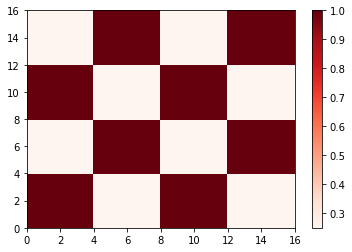

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('Reds')
plt.pcolormesh(x_pos, y_pos, D_mesh)
plt.colorbar()

In [52]:
flux_gs,j,s = DE_solver(x_pos, y_pos, D_mesh, abs_mesh, source_mesh, err_tol)
print(flux_gs,j,s)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.725967977194255, 25.744291375344563, 25.824026199723363, 24.617045936347896, 0.0, 25.744291375344563, 28.09603937698823, 28.3180477787452, 28.472158655822444, 0.0, 25.824026199723363, 28.3180477787452, 28.609677728917973, 29.072664327085086, 0.0, 24.617045936347896, 28.472158655822444, 29.072664327085086, 45.017301030258359] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.725969381249495, 25.744289891897989, 25.824022858193754, 24.617042965979618, 0.0, 25.744289891897989, 28.096034160097886, 28.318040241403764, 28.472149478731854, 0.0, 25.824022858193754, 28.318040241403764, 28.609667764630313, 29.072654056693477, 0.0, 24.617042965979618, 28.472149478731854, 29.072654056693477, 45.017292225682574] [-2.0000000000000123e-08, -2.0000000000000123e-08, -2.0000000000000123e-08, -2.0000000000000123e-08, -2.0000000000000123e-08, -2.0000000000000123e-08, 23.725880085896527, 25.744306635489075, 25.824053968825321, 24.617043376085171, -2.0000000000000123e-08, 25.74430663548907

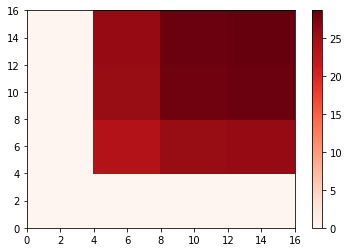

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pcolormesh(x_pos, y_pos,np.reshape(flux_gs,(len(y_pos),len(x_pos))) )
plt.colorbar()

In [54]:
x_pos = np.array([0,2,6,9,14,20,21,24])
y_pos = np.array([-8,-5,-1,4,10,17])
D_mesh = np.array([[1,1,1,1,1,1,1],
                  [1,1,0.25,1,0.25,1,1],
                  [0.25,1,1,1,1,1,0.25],
                  [1,0.25,1,1,1,0.25,1],
                  [1,1,0.25,0.25,0.25,1,1]])
abs_mesh = np.array([[0.5,0.5,0.5,0.5,0.5,0.5,0.5],
                  [0.5,0.5,0.2,0.5,0.2,0.5,0.5],
                  [0.2,0.5,0.5,0.5,0.5,0.5,0.2],
                  [0.5,0.2,0.5,0.5,0.5,0.2,0.5],
                  [0.5,0.5,0.2,0.2,0.2,0.5,0.5]])
source_mesh = np.array([[5,5,10,5,10,5,5],
                  [5,5,5,5,5,5,5],
                  [5,5,10,10,10,5,5],
                  [5,10,5,5,5,10,5],
                  [10,5,5,5,5,5,10]])
err_tol = 10**(-6)

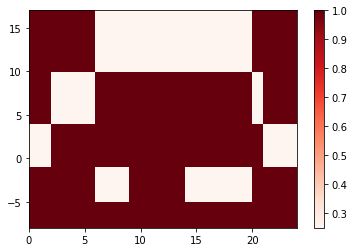

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap('Reds')
plt.pcolormesh(x_pos, y_pos, D_mesh)
plt.colorbar()

In [56]:
flux_gs,j,s = DE_solver(x_pos, y_pos, D_mesh, abs_mesh, source_mesh, err_tol)
print(flux_gs,j,s)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5950622006059131e-15, 12.849511661694063, 16.532329275880148, 14.789223860183757, 14.598380400155055, 15.260661744406727, 15.364810133723157, 14.903505190760104, 8.2410731459989673e-16, 14.883395188530812, 17.379298758208581, 15.020689350129139, 14.797274179363026, 15.475449948288469, 15.509455954067175, 14.298315116377069, -9.6462210266755041e-16, 9.9768541075095758, 13.989838046377539, 16.650110451890498, 17.636989286511596, 17.418735003409932, 15.439605925026628, 14.700801507477802, -2.7825791034309147e-15, 8.2877830962806005, 13.25019169236754, 13.786136613562379, 15.338138564164302, 16.542437895171066, 13.113272596868779, 11.262236921291578, 0.0, 8.1933553493692877, 13.488391650701899, 13.829526341059466, 15.386194393154382, 16.478828196515973, 12.949418655295066, 10.990977782726269] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.849511705495463, 16.532329392274157, 14.789224043143765, 14.598380763652017, 15.260662632726302, 15.36481040

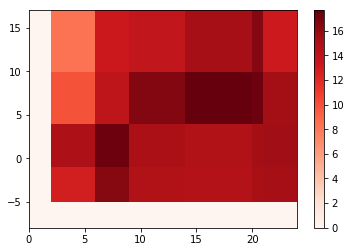

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pcolormesh(x_pos, y_pos,np.reshape(flux_gs,(len(y_pos),len(x_pos))) )
plt.colorbar()